# モデル学習

## Library Import

In [1]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

import datetime as dt

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../output/intermediate_file/'
model_path = '../output/model/'
oof_path = '../output/oof/'
fi_path = '../output/fi/'

# スクリプトのバージョン指定
fe_ver = 3
training_ver = 5
run_ver = 2 # モデル変更のない特徴量の更新についてはこちらで管理

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [3]:
train_df = pd.read_parquet(f'{intermediate_path}train_df_fe_v{fe_ver}.parquet')

In [4]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [5]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

#### カテゴリ型へ変更

In [6]:
cat_cols = ['building_category', 'land_area_kind', 'walk_distance_bin', 'building_land_chimoku',
            'land_chisei','land_road_cond', 'access_zone', 'fireproof_x_structure', 'structure_group'
]

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [7]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()
train_df[obj_cols] = train_df[obj_cols].astype('category')
cat_cols += obj_cols

## モデルの学習

In [8]:
# --- 東京23区 ---
TOKYO_23 = [
    '千代田区', '中央区', '港区', '新宿区', '文京区', '台東区',
    '墨田区', '江東区', '品川区', '目黒区', '大田区', '世田谷区',
    '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区',
    '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区'
]

# --- 政令指定都市 ---
SEIREI_CITIES = [
    '札幌市', '仙台市', 'さいたま市', '千葉市', '横浜市', '川崎市', '相模原市',
    '新潟市', '静岡市', '浜松市', '名古屋市',
    '京都市', '大阪市', '堺市', '神戸市',
    '岡山市', '広島市', '北九州市', '福岡市', '熊本市'
]

# --- 首都圏（都道府県） ---
CAPITAL_PREFS = ['東京都', '神奈川県', '埼玉県', '千葉県']

# --- 県庁所在地（市名のみ） ---
PREF_CAPITALS = [
    '札幌市','青森市','盛岡市','仙台市','秋田市','山形市','福島市',
    '水戸市','宇都宮市','前橋市','さいたま市','千葉市','新宿区',
    '横浜市','新潟市','富山市','金沢市','福井市','甲府市','長野市',
    '岐阜市','静岡市','名古屋市','津市','大津市','京都市','大阪市',
    '神戸市','奈良市','和歌山市','鳥取市','松江市','岡山市','広島市',
    '山口市','徳島市','高松市','松山市','高知市','福岡市','佐賀市',
    '長崎市','熊本市','大分市','宮崎市','鹿児島市','那覇市'
]

In [9]:
main_city = train_df.index[
    (
        (train_df['Prefecture name'] == '東京都') &
        (train_df['City/town/village name'].isin(TOKYO_23))
    )
    |
    (train_df['City/town/village name'].isin(['大阪市', '名古屋市']))
]

mid_city = train_df.index[
    (
        # 首都圏（23区除外）
        (
            train_df['Prefecture name'].isin(CAPITAL_PREFS)
            &
            ~(
                (train_df['Prefecture name'] == '東京都') &
                (train_df['City/town/village name'].isin(TOKYO_23))
            )
        )
        |
        # 政令指定都市
        (train_df['City/town/village name'].isin(SEIREI_CITIES))
        |
        # 県庁所在地
        (train_df['City/town/village name'].isin(PREF_CAPITALS))
    )
    &
    ~train_df.index.isin(main_city)
]

other = train_df.index[
    ~train_df.index.isin(main_city)
    &
    ~train_df.index.isin(mid_city)
]

urban_idx_dict = {
    'main_city': main_city,
    'mid_city': mid_city,
    'other': other,
}

In [10]:
idx_low_density = train_df.index[
    train_df['zone_residential_rank'] == 1
]

idx_mid_density = train_df.index[
    train_df['zone_residential_rank'] == 2
]

idx_high_density = train_df.index[
    train_df['zone_residential_rank'].isin([3, 4, 0]) |
    train_df['zone_residential_rank'].isna()
]

density_idx_dict = {
    'low': idx_low_density,
    'mid': idx_mid_density,
    'high': idx_high_density,
}

In [11]:
house_idx = train_df['building_category'] == 'house'
non_house_idx = ~house_idx

train_df_house = train_df[house_idx]
train_df_all = train_df[non_house_idx]

all_cols = fe_cols.copy()
house_cols = fe_cols.copy()

In [12]:
year_col = 'target_year'

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    'lgb': {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 100,
        'max_depth': -1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1
    },
    'cat': {
        'loss_function': 'RMSE',
        'depth': 8,
        'learning_rate': 0.05,
        'iterations': 2000,
        'l2_leaf_reg': 5,
        'random_seed': 42,
        'early_stopping_rounds': 200,
        'verbose': False,
    }
}

#### 関数

In [13]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))

In [14]:
def _infer_te_source_col(te_col: str) -> str:
    # "xxx_te" -> "xxx"
    return te_col[:-3] if te_col.endswith("_te") else te_col

def fit_target_encoding_map(
    s_cat: pd.Series,
    y: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
) -> tuple[pd.Series, float]:
    """
    1列のカテゴリ s_cat をターゲット y で target encoding するための mapping を作る。
    smoothing: 大きいほど全体平均に寄る（過学習防止）
    """
    s_cat = s_cat.astype("object")
    y = y.astype(float)

    prior = float(y.mean())

    stats = (
        pd.DataFrame({"cat": s_cat, "y": y})
          .groupby("cat")["y"]
          .agg(["count", "mean"])
    )

    # count が小さいカテゴリは prior に寄せる（smoothing + min_samples_leaf）
    count = stats["count"].astype(float)
    mean  = stats["mean"].astype(float)

    # smoothing 係数（一般的な ridge-like smoothing）
    # enc = (count*mean + smoothing*prior) / (count + smoothing)
    enc = (count * mean + smoothing * prior) / (count + smoothing)

    # さらに min_samples_leaf 未満は prior へ
    if min_samples_leaf > 1:
        enc[count < min_samples_leaf] = prior

    return enc, prior

def apply_target_encoding(
    s_cat: pd.Series,
    mapping: pd.Series,
    prior: float,
) -> pd.Series:
    s_cat = s_cat.astype("object")
    return s_cat.map(mapping).fillna(prior).astype(float)

def recompute_te_for_fold(
    train_df: pd.DataFrame,
    tr_idx: pd.Index,
    apply_idx_list: list[pd.Index],
    te_cols: list[str],
    y_tr: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
    verbose: bool = False,
) -> dict:
    """
    te_cols（例: eki_name1_te）の各列について、
    学習fold（tr_idx）だけでTEをfitし、apply_idx_list の各Indexへ適用する。

    返り値: {te_col: {"src_col":..., "mapping":..., "prior":...}} （必要なら保存用）
    """
    te_meta = {}

    for te_col in te_cols:
        src_col = _infer_te_source_col(te_col)
        if src_col not in train_df.columns:
            if verbose:
                print(f"[WARN] TE元列が見つからないためスキップ: {te_col} (src={src_col})")
            continue

        mapping, prior = fit_target_encoding_map(
            train_df.loc[tr_idx, src_col],
            y_tr.loc[tr_idx],
            smoothing=smoothing,
            min_samples_leaf=min_samples_leaf,
        )

        # 各適用先（train/val/ho など）へ適用
        for idx in apply_idx_list:
            train_df.loc[idx, te_col] = apply_target_encoding(
                train_df.loc[idx, src_col],
                mapping,
                prior
            ).values

        te_meta[te_col] = {"src_col": src_col, "mapping": mapping, "prior": prior}

    return te_meta

In [15]:
def run_cv_by_separate(
    train_df: pd.DataFrame,
    base_cols: list[str],
    target_col: str,
    year_col: str,
    base_params: dict,
    alg: str,
    idx_dict: dict[str, pd.Index],  # ← 追加
    n_splits: int = 5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
    cat_cols: list=False
):
    """
    都市区分ごとに CV / 最終モデル学習 / HO 予測を行う
    """

    y = train_df[target_col].astype(float)
    y_log = np.log(y)

    results = {}

    te_cols_base = [c for c in base_cols if c.endswith('_te')]

    for split_key, urban_idx in idx_dict.items():
        print(f'\n==============================')
        print(f' Urban class: {split_key}')
        print(f'==============================')

        # --- 年分割 ---
        idx_cv = urban_idx.intersection(train_df.index[train_df[year_col] <= 2021])
        idx_ho = urban_idx.intersection(train_df.index[train_df[year_col] == 2022])

        if len(idx_cv) == 0 or len(idx_ho) == 0:
            print(f'Skip {split_key} (no data)')
            continue

        y_ho = y.loc[idx_ho]

        print(f'CV rows: {len(idx_cv)}')
        print(f'HO rows: {len(idx_ho)}')

        # --- 初期化 ---
        oof_pred_log = pd.Series(np.nan, index=idx_cv, dtype=float)
        ho_pred_log_accum = pd.Series(0.0, index=idx_ho, dtype=float)

        ho_log_by_fold = []
        fi_list = []

        X_cv = train_df.loc[idx_cv, base_cols]
        y_cv_log = y_log.loc[idx_cv]
        groups_cv = train_df.loc[idx_cv, 'building_id']

        gkf = GroupKFold(n_splits=n_splits)

        # ======================
        # CV
        # ======================
        for fold, (tr_pos, va_pos) in enumerate(
            gkf.split(X_cv, y_cv_log, groups_cv), 1
        ):
            print(f'[{split_key}] Fold {fold}')

            tr_idx = idx_cv[tr_pos]
            va_idx = idx_cv[va_pos]

            # --- TE 再計算 ---
            if te_cols_base:
                recompute_te_for_fold(
                    train_df=train_df,
                    tr_idx=tr_idx,
                    apply_idx_list=[tr_idx, va_idx, idx_ho],
                    te_cols=te_cols_base,
                    y_tr=y_log,
                    smoothing=te_smoothing,
                    min_samples_leaf=te_min_samples_leaf,
                )

            # --- 学習 ---
            if alg == 'lgb':
                model = lgb.LGBMRegressor(**base_params[alg])
                model.fit(
                    train_df.loc[tr_idx, base_cols],
                    y_log.loc[tr_idx]
                )
            elif alg == 'cat':
                train_df[cat_cols] = train_df[cat_cols].astype('string').fillna('NA')
                model = CatBoostRegressor(**base_params[alg], cat_features=cat_cols)
                model.fit(
                    train_df.loc[tr_idx, base_cols],
                    y_log.loc[tr_idx]
                )

            # --- OOF ---
            va_pred_log = model.predict(train_df.loc[va_idx, base_cols])
            oof_pred_log.loc[va_idx] = va_pred_log

            # --- HO ---
            ho_pred_log = model.predict(train_df.loc[idx_ho, base_cols])
            ho_pred_log_accum += ho_pred_log / n_splits
            ho_log_by_fold.append(pd.Series(ho_pred_log, index=idx_ho))

            # --- FI ---
            if alg == 'lgb':
                fi_list.append(pd.DataFrame({
                    'feature': base_cols,
                    'importance': model.booster_.feature_importance(importance_type='gain'),
                    'fold': fold,
                    'urban': split_key,
                }))
            elif alg == 'cat':
                fi_list.append(pd.DataFrame({
                    'feature': base_cols,
                    'importance': model.get_feature_importance(type='PredictionValuesChange'),
                    'fold': fold,
                    'urban': split_key,
                }))

        # --- HO uncertainty ---
        ho_log_stack = pd.concat(ho_log_by_fold, axis=1)
        ho_mu = ho_log_stack.mean(axis=1)
        ho_sigma = ho_log_stack.std(axis=1)

        # ======================
        # 最終モデル（全CVデータ）
        # ======================
        print(f'[{split_key}] Final model training')

        if te_cols_base:
            recompute_te_for_fold(
                train_df=train_df,
                tr_idx=idx_cv,
                apply_idx_list=[idx_cv, idx_ho],
                te_cols=te_cols_base,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=True,
            )

        if alg == 'lgb':
            final_model = lgb.LGBMRegressor(**base_params[alg])
            final_model.fit(
                train_df.loc[idx_cv, base_cols],
                y_log.loc[idx_cv]
            )
        elif alg == 'cat':
            train_df[cat_cols] = train_df[cat_cols].astype('string').fillna('NA')
            final_model = CatBoostRegressor(**base_params[alg], cat_features=cat_cols)
            final_model.fit(
                train_df.loc[idx_cv, base_cols],
                y_log.loc[idx_cv]
            )

        ho_pred_log_final = pd.Series(
            final_model.predict(train_df.loc[idx_ho, base_cols]),
            index=idx_ho
        )

        # ======================
        # 保存
        # ======================
        results[split_key] = {
            'idx_cv': idx_cv,
            'idx_ho': idx_ho,

            'oof_pred_log': oof_pred_log,
            'ho_pred_log_cv_mean': ho_pred_log_accum,
            'ho_pred_log_final': ho_pred_log_final,

            'ho_mu': ho_mu,
            'ho_sigma': ho_sigma,

            'final_model': final_model,
            'fi': pd.concat(fi_list, ignore_index=True),
        }

    return results

#### house以外モデル

In [16]:
results_all = run_cv_by_separate(
    train_df=train_df_all,
    base_cols=all_cols,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=urban_idx_dict,
    cat_cols=cat_cols,  # catboost使うなら
)


 Urban class: main_city
CV rows: 32956
HO rows: 11506
[main_city] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31545
[LightGBM] [Info] Number of data points in the train set: 26364, number of used features: 373
[LightGBM] [Info] Start training from score 17.387255
[main_city] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be

In [17]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_all.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_all.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_all.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（all）
# =====================
oof_log_all = pd.concat(
    [res['oof_pred_log'] for res in results_all.values()]
).sort_index()

y_oof_all = train_df_all.loc[oof_log_all.index, target_col]
oof_pred_all = np.exp(oof_log_all)

oof_mape_all = mape(y_oof_all, oof_pred_all)
print(f'OOF MAPE (all, 2019–2021): {oof_mape_all:.6f}')

# =====================
# HO MAPE（all, final model）
# =====================
ho_log_all = pd.concat(
    [res['ho_pred_log_final'] for res in results_all.values()]
).sort_index()

y_ho_all = train_df_all.loc[ho_log_all.index, target_col]
ho_pred_all = np.exp(ho_log_all)

ho_mape_all = mape(y_ho_all, ho_pred_all)
print(f'HO MAPE (all, final model): {ho_mape_all:.6f}')

=== OOF MAPE by urban class ===
main_city  | OOF MAPE: 0.146670
mid_city   | OOF MAPE: 0.157677
other      | OOF MAPE: 0.174093

=== HO MAPE by urban class (final model) ===
main_city  | HO MAPE: 0.136243
mid_city   | HO MAPE: 0.153329
other      | HO MAPE: 0.145681
OOF MAPE (all, 2019–2021): 0.162380
HO MAPE (all, final model): 0.146066


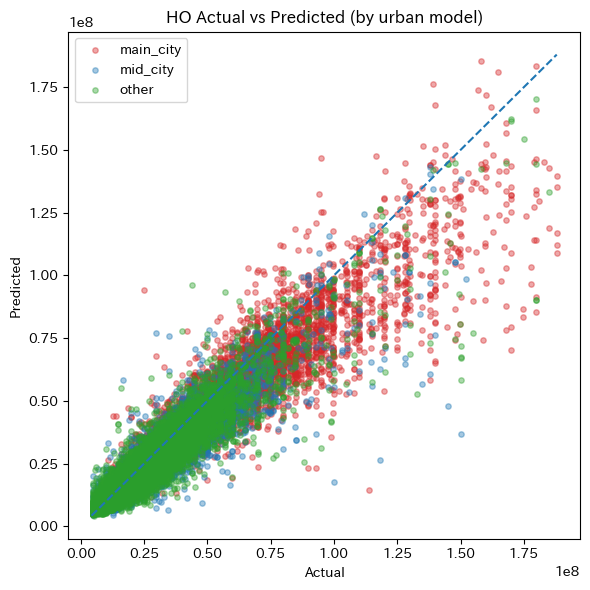

In [18]:
plt.figure(figsize=(6, 6))

color_map = {
    'main_city': 'tab:red',
    'mid_city':  'tab:blue',
    'other':     'tab:green',
}

for urban_key, res in results_all.items():
    idx_ho = res['idx_ho']
    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(res['ho_pred_log_final'])

    plt.scatter(
        y_true,
        y_pred,
        alpha=0.4,
        s=15,
        label=urban_key,
        color=color_map.get(urban_key, 'gray'),
    )

# ===== 45度線 =====
all_y = pd.concat([
    train_df_all.loc[res['idx_ho'], target_col]
    for res in results_all.values()
])

all_pred = pd.concat([
    np.exp(res['ho_pred_log_final'])
    for res in results_all.values()
])

min_val = min(all_y.min(), all_pred.min())
max_val = max(all_y.max(), all_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle='--',
)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('HO Actual vs Predicted (by urban model)')
plt.legend()
plt.tight_layout()
plt.show()

#### houseモデル

In [19]:
results_house = run_cv_by_separate(
    train_df=train_df_house,
    base_cols=house_cols,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=density_idx_dict,
    cat_cols=cat_cols
)


 Urban class: low
CV rows: 36404
HO rows: 11353
[low] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38439
[LightGBM] [Info] Number of data points in the train set: 29123, number of used features: 347
[LightGBM] [Info] Start training from score 16.893970
[low] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a la

In [20]:
print('=== OOF MAPE by density class ===')

for density_key, res in results_house.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_house.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{density_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by density class (final model) ===')

for density_key, res in results_house.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{density_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（house）
# =====================
oof_log_house = pd.concat(
    [res['oof_pred_log'] for res in results_house.values()]
).sort_index()

y_oof_house = train_df_house.loc[oof_log_house.index, target_col]
oof_pred_house = np.exp(oof_log_house)

oof_mape_house = mape(y_oof_house, oof_pred_house)
print(f'OOF MAPE (house, 2019–2021): {oof_mape_house:.6f}')

# =====================
# HO MAPE（house, final model）
# =====================
ho_log_house = pd.concat(
    [res['ho_pred_log_final'] for res in results_house.values()]
).sort_index()

y_ho_house = train_df_house.loc[ho_log_house.index, target_col]
ho_pred_house = np.exp(ho_log_house)

ho_mape_house = mape(y_ho_house, ho_pred_house)
print(f'HO MAPE (house, final model): {ho_mape_house:.6f}')

=== OOF MAPE by density class ===
low        | OOF MAPE: 0.180605
mid        | OOF MAPE: 0.186148
high       | OOF MAPE: 0.200619

=== HO MAPE by density class (final model) ===
low        | HO MAPE: 0.159913
mid        | HO MAPE: 0.159266
high       | HO MAPE: 0.167709
OOF MAPE (house, 2019–2021): 0.191442
HO MAPE (house, final model): 0.163761


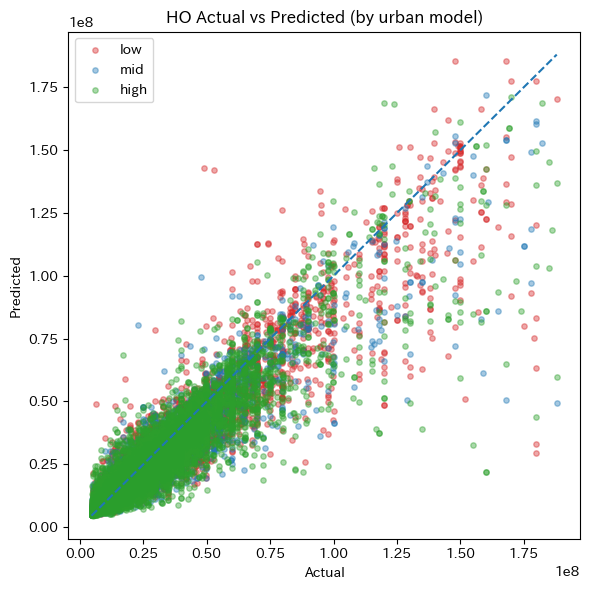

In [21]:
plt.figure(figsize=(6, 6))

color_map = {
    'low':  'tab:red',
    'mid':  'tab:blue',
    'high': 'tab:green',
}

for urban_key, res in results_house.items():
    idx_ho = res['idx_ho']
    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(res['ho_pred_log_final'])

    plt.scatter(
        y_true,
        y_pred,
        alpha=0.4,
        s=15,
        label=urban_key,
        color=color_map.get(urban_key, 'gray'),
    )

# ===== 45度線 =====
house_y = pd.concat([
    train_df_house.loc[res['idx_ho'], target_col]
    for res in results_house.values()
])

house_pred = pd.concat([
    np.exp(res['ho_pred_log_final'])
    for res in results_house.values()
])

min_val = min(house_y.min(), house_pred.min())
max_val = max(house_y.max(), house_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle='--',
)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('HO Actual vs Predicted (by urban model)')
plt.legend()
plt.tight_layout()
plt.show()

## 特徴量重要度

In [22]:
all_base_fi_by_urban = {}

for urban_key, res in results_all.items():
    fi_df_raw = res['fi']  # ← これは DataFrame

    fi_df = (
        fi_df_raw
        .groupby('feature', as_index=False)['importance']
        .mean()
        .sort_values('importance', ascending=False)
    )

    all_base_fi_by_urban[urban_key] = fi_df
    print(urban_key)
    display(all_base_fi_by_urban[urban_key].head(20))


house_base_fi_by_density = {}

for density_key, res in results_house.items():
    fi_df_raw = res['fi']  # ← DataFrame

    fi_df = (
        fi_df_raw
        .groupby('feature', as_index=False)['importance']
        .mean()
        .sort_values('importance', ascending=False)
    )

    house_base_fi_by_density[density_key] = fi_df
    print(density_key)
    display(house_base_fi_by_density[density_key].head(20))


main_city


,feature,importance
156,madori_kind_all,15463.321873
182,money_kyoueki_std,9902.947265
231,senyu_area_log,8017.209976
151,log_weighted_land_price_3_x_livability_score,7778.974100
147,log_weighted_land_price_3_x_age_decay_30,4287.119111
52,eki_name1,3697.788631
53,eki_name1_te,2920.491879
194,premium_equipment_count,1901.272521
229,score_building,1425.486015
140,log_land_price_x_age_decay_30,1408.929241


mid_city


,feature,importance
147,log_weighted_land_price_3_x_age_decay_30,21508.539687
140,log_land_price_x_age_decay_30,15434.977654
151,log_weighted_land_price_3_x_livability_score,15092.211586
52,eki_name1,6933.430924
156,madori_kind_all,6309.633744
231,senyu_area_log,6185.477267
194,premium_equipment_count,5702.075117
0,City/town/village name,5065.634865
164,mean_price_1000m_log,4863.923133
175,median_price_1000m_log,3996.870327


other


,feature,importance
147,log_weighted_land_price_3_x_age_decay_30,33709.555671
156,madori_kind_all,15760.274488
140,log_land_price_x_age_decay_30,15010.429800
151,log_weighted_land_price_3_x_livability_score,14578.219363
0,City/town/village name,10490.521955
231,senyu_area_log,7960.331887
194,premium_equipment_count,7838.018759
53,eki_name1_te,7286.566537
52,eki_name1,7163.427639
182,money_kyoueki_std,6160.008379


low


,feature,importance
118,land_theoretical_price_weighted,36280.150944
117,land_theoretical_price,15119.599771
131,land_theoretical_price_x_age_decay_30,8268.183049
119,land_theoretical_price_weighted_x_age_decay_30,5085.682005
140,log_land_price_x_age_decay_30,3698.255507
53,eki_name1_te,3580.960863
0,City/town/village name,3404.813729
124,land_theoretical_price_weighted_x_senyu,3252.191596
51,effective_land_price,2215.514172
136,land_theoretical_price_x_senyu,1932.124330


mid


,feature,importance
118,land_theoretical_price_weighted,11071.615030
53,eki_name1_te,9996.780436
131,land_theoretical_price_x_age_decay_30,6355.006387
117,land_theoretical_price,4564.594468
135,land_theoretical_price_x_livability_score,3941.255783
119,land_theoretical_price_weighted_x_age_decay_30,3641.756204
51,effective_land_price,3293.806264
124,land_theoretical_price_weighted_x_senyu,3048.985540
136,land_theoretical_price_x_senyu,3008.665340
0,City/town/village name,1393.492970


high


,feature,importance
53,eki_name1_te,24504.088745
151,log_weighted_land_price_3_x_livability_score,20023.268169
124,land_theoretical_price_weighted_x_senyu,13334.050391
119,land_theoretical_price_weighted_x_age_decay_30,9830.698138
118,land_theoretical_price_weighted,9210.828893
0,City/town/village name,8964.840817
51,effective_land_price,7470.647006
147,log_weighted_land_price_3_x_age_decay_30,7261.484507
136,land_theoretical_price_x_senyu,7045.035531
131,land_theoretical_price_x_age_decay_30,6048.742568


In [23]:
all_base_fi_all = (
    pd.concat(
        [
            res['fi'].assign(urban=urban_key)
            for urban_key, res in results_all.items()
        ],
        ignore_index=True,
    )
    .groupby('feature', as_index=False)['importance']
    .mean()
    .sort_values('importance', ascending=False)
)

house_base_fi_all = (
    pd.concat(
        [
            res['fi'].assign(density=density_key)
            for density_key, res in results_house.items()
        ],
        ignore_index=True,
    )
    .groupby('feature', as_index=False)['importance']
    .mean()
    .sort_values('importance', ascending=False)
)

In [24]:
all_base_fi_all.to_csv(f'{fi_path}feature_importance_all_{run_ver}.csv', index=False)
house_base_fi_all.to_csv(f'{fi_path}feature_importance_house_{run_ver}.csv', index=False)

#### 特徴量重要度==0を削除

In [25]:
excluded_fe_all_base = all_base_fi_all.query('importance == 0')['feature'].tolist()
excluded_fe_house_base = house_base_fi_all.query('importance == 0')['feature'].tolist()

print(f'[ALL] Removed {len(excluded_fe_all_base)} features')
print(f'[HOUSE] Removed {len(excluded_fe_house_base)} features')

all_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_base]
house_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_base]

[ALL] Removed 61 features
[HOUSE] Removed 83 features


#### house以外モデル

In [26]:
results_all = run_cv_by_separate(
    train_df=train_df_all,
    base_cols=all_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=urban_idx_dict,
)


 Urban class: main_city


CV rows: 32956
HO rows: 11506
[main_city] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31521
[LightGBM] [Info] Number of data points in the train set: 26364, number of used features: 361
[LightGBM] [Info] Start training from score 17.387255
[main_city] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large num

In [27]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_all.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_all.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_all.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（all）
# =====================
oof_log_all = pd.concat(
    [res['oof_pred_log'] for res in results_all.values()]
).sort_index()

y_oof_all = train_df_all.loc[oof_log_all.index, target_col]
oof_pred_all = np.exp(oof_log_all)

oof_mape_all = mape(y_oof_all, oof_pred_all)
print(f'OOF MAPE (all, 2019–2021): {oof_mape_all:.6f}')

# =====================
# HO MAPE（all, final model）
# =====================
ho_log_all = pd.concat(
    [res['ho_pred_log_final'] for res in results_all.values()]
).sort_index()

y_ho_all = train_df_all.loc[ho_log_all.index, target_col]
ho_pred_all = np.exp(ho_log_all)

ho_mape_all = mape(y_ho_all, ho_pred_all)
print(f'HO MAPE (all, final model): {ho_mape_all:.6f}')

=== OOF MAPE by urban class ===
main_city  | OOF MAPE: 0.146815
mid_city   | OOF MAPE: 0.157506
other      | OOF MAPE: 0.173965

=== HO MAPE by urban class (final model) ===
main_city  | HO MAPE: 0.135141
mid_city   | HO MAPE: 0.152681
other      | HO MAPE: 0.145625
OOF MAPE (all, 2019–2021): 0.162293
HO MAPE (all, final model): 0.145576


In [ ]:
# === OOF MAPE by urban class ===
# main_city  | OOF MAPE: 0.146815
# mid_city   | OOF MAPE: 0.157506
# other      | OOF MAPE: 0.173965

# === HO MAPE by urban class (final model) ===
# main_city  | HO MAPE: 0.135141
# mid_city   | HO MAPE: 0.152681
# other      | HO MAPE: 0.145625
# OOF MAPE (all, 2019–2021): 0.162293
# HO MAPE (all, final model): 0.145576

#### houseモデル

In [29]:
cat_cols_filtered = [c for c in cat_cols if c not in excluded_fe_house_base]

In [30]:
results_house = run_cv_by_separate(
    train_df=train_df_house,
    base_cols=house_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=density_idx_dict,
    cat_cols=cat_cols_filtered
)


 Urban class: low
CV rows: 36404
HO rows: 11353
[low] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38435
[LightGBM] [Info] Number of data points in the train set: 29123, number of used features: 345
[LightGBM] [Info] Start training from score 16.893970
[low] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a la

In [31]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_house.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_house.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_house.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（house）
# =====================
oof_log_house = pd.concat(
    [res['oof_pred_log'] for res in results_house.values()]
).sort_index()

y_oof_house = train_df_house.loc[oof_log_house.index, target_col]
oof_pred_house = np.exp(oof_log_house)

oof_mape_house = mape(y_oof_house, oof_pred_house)
print(f'OOF MAPE (house, 2019–2021): {oof_mape_house:.6f}')

# =====================
# HO MAPE（house, final model）
# =====================
ho_log_house = pd.concat(
    [res['ho_pred_log_final'] for res in results_house.values()]
).sort_index()

y_ho_house = train_df_house.loc[ho_log_house.index, target_col]
ho_pred_house = np.exp(ho_log_house)

ho_mape_house = mape(y_ho_house, ho_pred_house)
print(f'HO MAPE (house, final model): {ho_mape_house:.6f}')

=== OOF MAPE by urban class ===
low        | OOF MAPE: 0.180555
mid        | OOF MAPE: 0.186540
high       | OOF MAPE: 0.201168

=== HO MAPE by urban class (final model) ===
low        | HO MAPE: 0.159967
mid        | HO MAPE: 0.159385
high       | HO MAPE: 0.168051
OOF MAPE (house, 2019–2021): 0.191770
HO MAPE (house, final model): 0.163975


In [ ]:
# === OOF MAPE by urban class ===
# low        | OOF MAPE: 0.180555
# mid        | OOF MAPE: 0.186540
# high       | OOF MAPE: 0.201168

# === HO MAPE by urban class (final model) ===
# low        | HO MAPE: 0.159967
# mid        | HO MAPE: 0.159385
# high       | HO MAPE: 0.168051
# OOF MAPE (house, 2019–2021): 0.191770
# HO MAPE (house, final model): 0.163975

#### 学習データの予測結果出力

In [33]:
# ============================================================
# 1) 予測結果を格納する DataFrame
# ============================================================
train_result_df_all = train_df_all[fe_cols + [target_col]].copy()
train_result_df_house = train_df_house[fe_cols + [target_col]].copy()

train_result_df_all['oof_pred'] = np.nan
train_result_df_all['ho_pred'] = np.nan
train_result_df_house['oof_pred'] = np.nan
train_result_df_house['ho_pred'] = np.nan

# --- HO のマスク（2022年） ---
mask_ho_all = train_result_df_all['target_ym'].astype(str).str.startswith('2022')
mask_ho_house = train_result_df_house['target_ym'].astype(str).str.startswith('2022')

# index が完全一致するのでそのまま代入可
train_result_df_all.loc[~mask_ho_all,     'oof_pred'] = oof_pred_all
train_result_df_all.loc[mask_ho_all,      'ho_pred'] = ho_pred_all
train_result_df_house.loc[~mask_ho_house, 'oof_pred'] = oof_pred_house
train_result_df_house.loc[mask_ho_house,  'ho_pred'] = ho_pred_house

# 保存
train_result_df = pd.concat([train_result_df_all, train_result_df_house], axis=0)
train_result_df.to_csv(f'{oof_path}oof_{today}_{run_ver}.csv', index=False)

## 最終モデル

In [34]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
all_base_cols = all_cols_filtered.copy()
house_base_cols = house_cols_filtered.copy()

y_all     = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

# building_category で house / 非 house に分割
idx_non_house = train_df.index[non_house_idx]
idx_house     = train_df.index[house_idx]

In [35]:
def train_final_models_by_split(
    train_df: pd.DataFrame,
    feature_cols: list[str],
    y_log: pd.Series,
    alg: str,
    params: dict,
    idx_dict: dict[str, pd.Index],
    idx: pd.Index | None = None,   # ← 追加（学習母集合の制限）
    cat_cols=None,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
) -> dict[str, lgb.LGBMRegressor]:

    if idx is None:
        idx = train_df.index
    else:
        idx = pd.Index(idx).intersection(train_df.index)  # 念のため母集合を揃える

    models: dict[str, lgb.LGBMRegressor] = {}
    te_cols = [c for c in feature_cols if c.endswith('_te')]

    for split_key, split_idx in idx_dict.items():
        if split_idx is None or len(split_idx) == 0:
            print(f'Skip {split_key} (empty split_idx)')
            continue

        # ★ run_cv_by_separate と同様に必ず交差を取る
        idx_use = pd.Index(split_idx).intersection(idx)

        if len(idx_use) == 0:
            print(f'Skip {split_key} (no rows after intersection)')
            continue

        print(f'=== Final model training: {split_key} | rows={len(idx_use)} ===')

        df_local = train_df.copy()

        # --- split内TE（任意） ---
        if te_cols:
            # split内の母集団 idx_use だけで mapping を作り、idx_use に適用
            # y_tr は y_log をそのまま渡してOK（関数内で tr_idx を参照して使う想定）
            recompute_te_for_fold(
                train_df=df_local,
                tr_idx=idx_use,
                apply_idx_list=[idx_use],
                te_cols=te_cols,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf
            )

        X_tr = df_local.loc[idx_use, feature_cols]
        y_tr = y_log.loc[idx_use]

        if alg == 'lgb':
            model = lgb.LGBMRegressor(**params[alg])
            model.fit(X_tr, y_tr)
        elif alg == 'cat':
            # cat_cols は外側スコープ/引数で渡してください
            model = CatBoostRegressor(**params[alg], cat_features=cat_cols)
            model.fit(X_tr, y_tr)
        else:
            raise ValueError(f'Unknown alg: {alg}')

        models[split_key] = model

    return models

In [36]:
final_models_all_by_urban = train_final_models_by_split(
    train_df=train_df_all,
    feature_cols=all_base_cols,
    y_log=np.log(train_df_all[target_col].astype(float)),
    alg='lgb',
    params=base_params,
    idx_dict=urban_idx_dict,
    idx=idx_non_house,
)

=== Final model training: main_city | rows=44462 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32572
[LightGBM] [Info] Number of data points in the train set: 44462, number of used features: 367
[LightGBM] [Info] Start training from score 17.415360
=== Final model training: mid_city | rows=75788 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_fe

In [37]:
final_models_house_by_density = train_final_models_by_split(
    train_df=train_df_house,
    feature_cols=house_base_cols,
    y_log=np.log(train_df_house[target_col].astype(float)),
    alg='lgb',
    params=base_params,
    idx_dict=density_idx_dict,
    idx=idx_house,
    cat_cols=cat_cols_filtered
)

=== Final model training: low | rows=47757 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39761
[LightGBM] [Info] Number of data points in the train set: 47757, number of used features: 349
[LightGBM] [Info] Start training from score 16.912679
=== Final model training: mid | rows=29990 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may b

## モデルの出力

In [38]:
import pickle
all_base_dict = {
    'all_model': {
        'main_city': final_models_all_by_urban['main_city'],
        'mid_city': final_models_all_by_urban['mid_city'],
        'other': final_models_all_by_urban['other']
    },
    'all_base_cols': all_cols_filtered
}
house_base_dict = {
    'house_model': {
        'low': final_models_house_by_density['low'],
        'mid': final_models_house_by_density['mid'],
        'high': final_models_house_by_density['high']
    },
    'house_base_cols': house_cols_filtered,
    'cat_cols': cat_cols_filtered 
}

with open(f'{model_path}all_base_model_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(all_base_dict, f)
with open(f'{model_path}house_base_model_v{training_ver}.pkl', 'wb') as f:
    pickle.dump(house_base_dict, f)

In [39]:
all_base_fi_all

,feature,importance
147,log_weighted_land_price_3_x_age_decay_30,19835.071490
156,madori_kind_all,12511.076702
151,log_weighted_land_price_3_x_livability_score,12483.135017
140,log_land_price_x_age_decay_30,10618.112232
231,senyu_area_log,7387.673043
...,...,...
288,専有部分設備_トイレ_トイレなし,0.000000
15,area_ratio,0.000000
275,専有部分設備_キッチン_ガスコンロ,0.000000
271,土地価格_敷地延長・変形地,0.000000


In [40]:
null_df = (
    pd.DataFrame({
        'null_cnt': train_df.isna().sum(),
        'null_rate': train_df.isna().mean()
    })
    .reset_index()
    .rename(columns={'index': 'feature'})
)

all_fi = (
    all_base_fi_all[['feature', 'importance']]
        .rename(columns={'importance': 'importance_all'})
)

house_fi = (
    house_base_fi_all[['feature', 'importance']]
        .rename(columns={'importance': 'importance_house'})
)

fi_merged = (
    all_fi
        .merge(house_fi, on='feature', how='outer')
        .merge(null_df, on='feature', how='left')
)

fi_merged[['importance_all', 'importance_house']] = (
    fi_merged[['importance_all', 'importance_house']].fillna(0)
)

In [41]:
candidates = fi_merged[
    ((fi_merged['importance_house'] > 0) | (fi_merged['importance_all'] > 0)) &
    (fi_merged['null_rate'] >= 0.05)
].sort_values(
    ['importance_house', 'importance_all', 'null_rate'],
    ascending=[False, False, False]
)

candidates.head(20)


,feature,importance_all,importance_house,null_cnt,null_rate
118,land_theoretical_price_weighted,901.516362,18854.198289,198347,0.545023
117,land_theoretical_price,736.869652,7268.512502,198347,0.545023
131,land_theoretical_price_x_age_decay_30,0.196455,6890.644001,213082,0.585512
124,land_theoretical_price_weighted_x_senyu,0.000000,6545.075843,210469,0.578332
119,land_theoretical_price_weighted_x_age_decay_30,1.070382,6186.045449,213082,0.585512
136,land_theoretical_price_x_senyu,0.000000,3995.275067,210469,0.578332
123,land_theoretical_price_weighted_x_livability_s...,217.047505,1781.237993,198347,0.545023
135,land_theoretical_price_x_livability_score,128.299340,1583.448619,198347,0.545023
13,area_per_room,172.771684,1276.672406,26052,0.071586
126,land_theoretical_price_within1km_mp_x_age_deca...,0.120287,852.233908,213082,0.585512
